# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

##### Listing 3.1

In [56]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [57]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

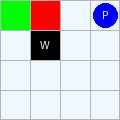

In [58]:
from GridBoardRenderer import render_color
my_colors = {
        'Player': (0, 0, 255),     # Blue
        'Goal':   (0, 255, 0),     # Bright Green
        'Pit':    (255, 0, 0),     # Red
        'boundary': (64, 64, 64), # Dark Gray
        'Wall': (0, 0, 0), # Black
    }
render_color(game.board, color_map=my_colors, cell_size=30)

Generating 4 frames for GIF...
Rendering frame 1/4... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 2/4... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 3/4... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 4/4... Warning: Using default bitmap font, which may be pixelated at size 30.

Frame rendering complete.
Generating GIF object for display...
GIF object generated.
Returning IPython.display.Image object.


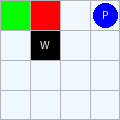

In [59]:
from GridBoardRenderer import create_gif

game = Gridworld(size=4, mode='static')
trajectory = [game.board.copy()]
game.makeMove('d')
trajectory.append(game.board.copy())
game.makeMove('d')
trajectory.append(game.board.copy())
game.makeMove('l')
trajectory.append(game.board.copy())
game.display()
gif = create_gif(trajectory,filename=None,color_map=my_colors,cell_size=30)
display(gif)

In [60]:
game.reward()

-1

In [61]:
game.board.render_np()
  

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

##### Listing 3.2: Define the Neural network

In [62]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

q_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

##### Listing 3.3

In [123]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [64]:
def epsilon_greedy_policy(qval, epsilon):
    """
    Select an action using epsilon-greedy strategy

    Args:
        qval: Q-values for the current state (numpy array)
        epsilon: Exploration rate

    Returns:
        action: Selected action
    """
    if random.random() < epsilon:
        return np.random.randint(0,4)
    else:
        return np.argmax(qval)


In [65]:
def findMaxQ(model,state):
    """
    Compute the maximum Q-value for a given state
    """
    with torch.no_grad():
            newQ = model(state.reshape(1,64))
    maxQ = torch.max(newQ) #M
    return maxQ



# Classic Q-learning with a neural network
I am calling this classic Q-learning as this does not include experience replay nor target networks.

In [66]:
from tqdm import tqdm
epochs = 1000
losses = [] # Keep track of losses
pbar = tqdm(range(epochs))
for i in pbar: # Iterate over epochs
    game = Gridworld(size=4, mode='static') # Initialize a new game for this epoch
    # Add noise to the state 
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
    # Convert to a torch tensor
    state = torch.from_numpy(state_).float() 
    
    game_in_progress = True 
    while(game_in_progress): # Loop until the game is over

        # Forward pass to get Q-values
        qval = q_model(state) 
        # Convert to numpy array
        qval_ = qval.data.numpy()

        # Select an action using epsilon-greedy strategy
        action_ = epsilon_greedy_policy(qval_, epsilon)
       
        action= action_set[action_] 
        game.makeMove(action) # Make the move
        # Get the next state
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()

        # Update the Q-value for the current state-action pair
        if reward == -1: #N
            maxQ = findMaxQ(q_model,state2)
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        loss = loss_fn(X, Y) #P
        
        pbar.set_postfix({'loss': f"{loss.item():.6f}"})
        
        # Clear the gradients   
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Append the loss to the list of losses
        losses.append(loss.item())
        # Update the parameters
        optimizer.step()
        # Update the current state
        state = state2
        # Check for game over
        if reward != -1: #Q
            game_in_progress = False
    # Epsilon decay
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]/workspaces/rl_resources/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s, loss=0.093203]


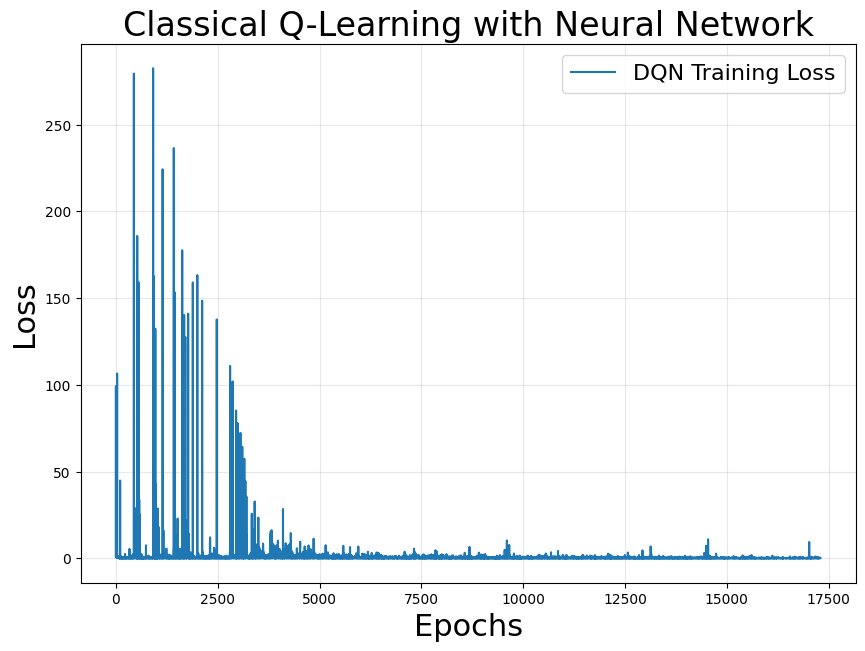

In [67]:
plt.figure(figsize=(10,7))
plt.plot(losses, label='DQN Training Loss')
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)
plt.title("Classical Q-Learning with Neural Network", fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)

##### Listing 3.4

In [68]:
from GridBoardRenderer import create_gif
def test_model(model, mode='static', display=True, gif=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
  
    trajectory = []
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        trajectory.append(test_game.board.copy())
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False

    if gif:
        return win, create_gif(trajectory)
    return win, None

Initial State:
[[' ' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' ' ' '-' ' ']
 ['P' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 6; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 7; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 8; Taking action: l
[['P' ' ' '-' ' ']
 [' ' '+' ' ' ' ']
 [

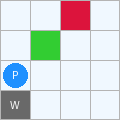

In [70]:
win, gif=test_model(q_model, 'random', display=True, gif=True)
print(win)
display(gif)

# Performance over 1000 games against 'static', 'player' and 'random

In [71]:
def test_model_1000_games(model):
    static_board_games = []

    player_board_games = []

    random_board_games = []

    for i in tqdm(range(1000)):

        win,_=test_model(model, 'static', display=False, gif=False)
        static_board_games.append(win)

        win, _=test_model(model, 'player', display=False, gif=False)
        player_board_games.append(win)

        win, _=test_model(model, 'random', display=False, gif=False)
        random_board_games.append(win)

    return static_board_games, player_board_games, random_board_games




In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Optional: for easy stats calculation

def plot_model_test_results(title,static_board_games, player_board_games, random_board_games):
    # Assuming static_board_games, player_board_games, random_board_games exist
    # Convert boolean wins to 1s and losses to 0s if they aren't already
    static_wins = np.array(static_board_games).astype(int)
    player_wins = np.array(player_board_games).astype(int)
    random_wins = np.array(random_board_games).astype(int)

    # Calculate mean win rates
    n_games = len(static_wins) # Should be 1000
    mean_static = np.mean(static_wins)
    mean_player = np.mean(player_wins)
    mean_random = np.mean(random_wins)

    # Calculate standard error of the mean (for error bars)
    # For binomial proportion, SE = sqrt(p*(1-p)/n)
    stderr_static = np.sqrt(mean_static * (1 - mean_static) / n_games)
    stderr_player = np.sqrt(mean_player * (1 - mean_player) / n_games)
    stderr_random = np.sqrt(mean_random * (1 - mean_random) / n_games)

    # --- Create Bar Chart ---
    modes = ['Static', 'Player', 'Random']
    win_rates = [mean_static, mean_player, mean_random]
    # Error bars representing +/- 1 standard error
    error_bars = [stderr_static, stderr_player, stderr_random]
    # Or use 1.96 * stderr for approximate 95% confidence interval

    plt.figure(figsize=(8, 6))
    bars = plt.bar(modes, win_rates, yerr=error_bars, capsize=5, color=['skyblue', 'lightcoral', 'lightgreen'])

    plt.ylabel("Win Rate", fontsize=14)
    plt.title(title, fontsize=16)
    plt.ylim(0, 1.1) # Win rate is between 0 and 1
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add text labels for win rates on bars
    for bar, rate in zip(bars, win_rates):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{rate:.3f}", ha='center', va='bottom', fontsize=11)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout
    plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 181.07it/s]


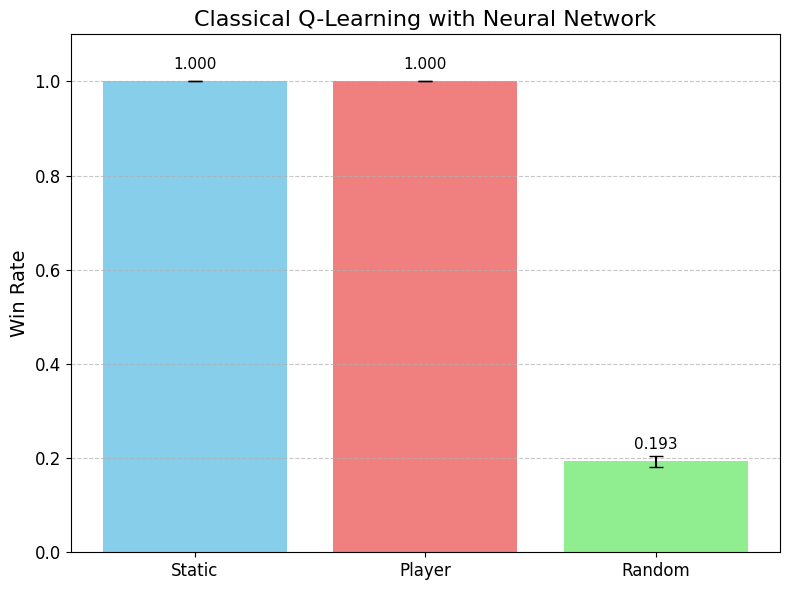

In [73]:
static_board_games, player_board_games, random_board_games = test_model_1000_games(q_model)
plot_model_test_results("Classical Q-Learning with Neural Network", static_board_games, player_board_games, random_board_games)

# Q-Learning with Experience Replay

## Define the same model, and rename it 'qe_model'

In [75]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

qe_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(qe_model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(qe_model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

## Training loop Q-Learning with a Neural Network and Experience Replay

In [77]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
pbar = tqdm(range(epochs))
for i in pbar:
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = qe_model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = qe_model(state1_batch) #L
            with torch.no_grad():
                Q2 = qe_model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            pbar.set_postfix({'loss': f"{loss.item():.6f}"})
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

100%|██████████| 5000/5000 [04:49<00:00, 17.27it/s, loss=0.034879]


In [78]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

<Figure size 1000x700 with 0 Axes>

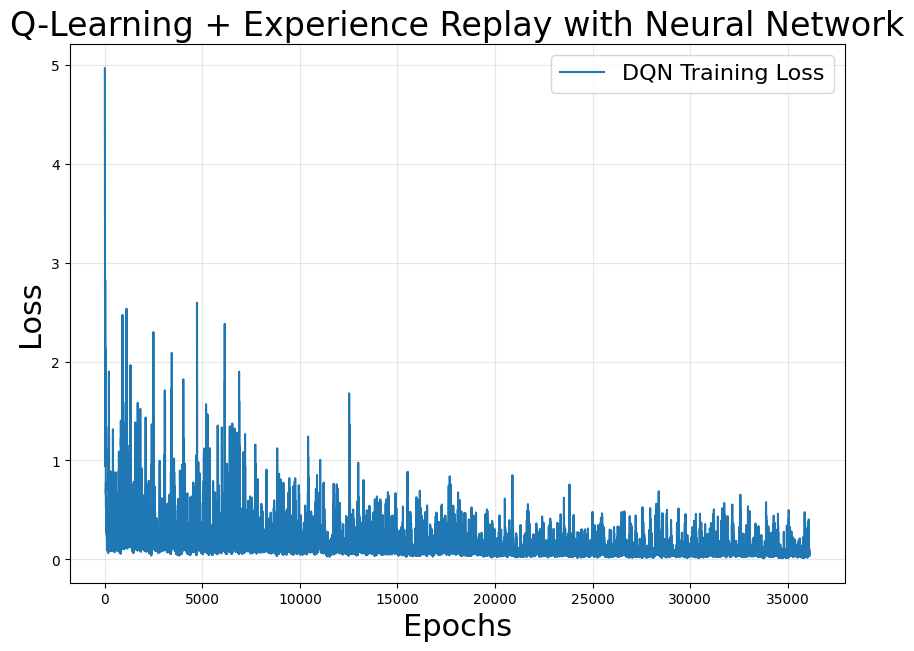

In [79]:
plt.figure(figsize=(10,7))
plt.figure(figsize=(10,7))
plt.plot(losses, label='DQN Training Loss')
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)
plt.title("Q-Learning + Experience Replay with Neural Network", fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)

100%|██████████| 1000/1000 [00:03<00:00, 317.68it/s]


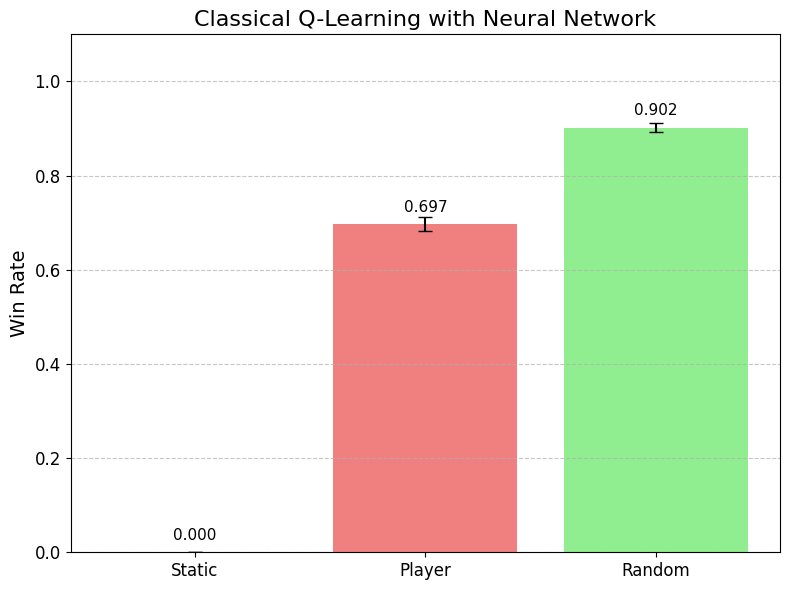

In [80]:
static_board_games, player_board_games, random_board_games = test_model_1000_games(qe_model)
plot_model_test_results("Classical Q-Learning with Neural Network", static_board_games, player_board_games, random_board_games)

In [81]:
max_games = 1000
wins = 0
for i in range(max_games):
    win,_ = test_model(qe_model, mode='random', display=False, gif=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 924
Win percentage: 92.4%


Generating 3 frames for GIF...
Rendering frame 1/3... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 2/3... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 3/3... Warning: Using default bitmap font, which may be pixelated at size 30.

Frame rendering complete.
Generating GIF object for display...
GIF object generated.
Returning IPython.display.Image object.
True


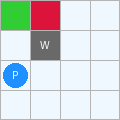

In [88]:
win, gif = test_model(qe_model, mode='player', display=False, gif=True)
print(win)
display(gif)

# Full DQN solution

In [108]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


input_dim = 64
hidden_layers_dims =[ 150,300,150,100]

output_dim = 4

class DQN(torch.nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_layers_dims) -> None:
        super().__init__()
        self.activation = torch.nn.ReLU()

        self.input_layer = torch.nn.Linear(input_dim, hidden_layers_dims[0])
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_layers_dims[i], hidden_layers_dims[i+1]) for i in range(len(hidden_layers_dims)-1)])
        self.output_layer = torch.nn.Linear(hidden_layers_dims[-1], output_dim)

    def forward(self, state):
        x = state

        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        
       

        x = self.activation(self.input_layer(x))

        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        x = self.output_layer(x)

        return x
    

dqn_model = DQN(input_dim, output_dim, hidden_layers_dims)

model2 = copy.deepcopy(dqn_model) #A
model2.load_state_dict(dqn_model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(dqn_model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [113]:
from collections import deque
epochs = 10000
losses = []
mem_size = 5000
batch_size = 400
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
pbar = tqdm(range(epochs))
for i in pbar:
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = dqn_model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = dqn_model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            pbar.set_postfix({'loss': f"{loss.item():.6f}"})
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(dqn_model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

100%|██████████| 10000/10000 [11:55<00:00, 13.97it/s, loss=0.003907]


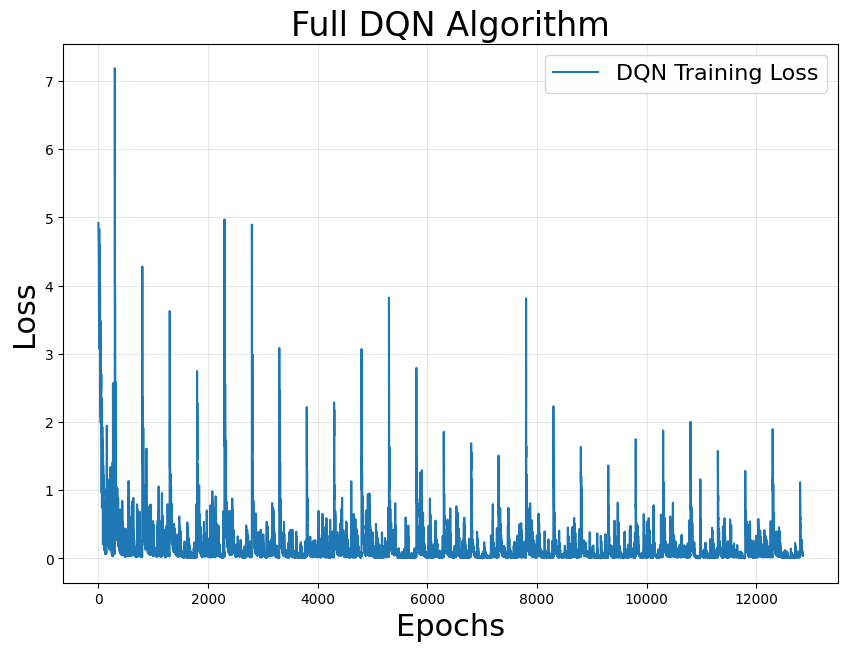

In [110]:
plt.figure(figsize=(10,7))
plt.plot(losses, label='DQN Training Loss')
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)
plt.title("Full DQN Algorithm", fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)

100%|██████████| 1000/1000 [00:03<00:00, 318.68it/s]


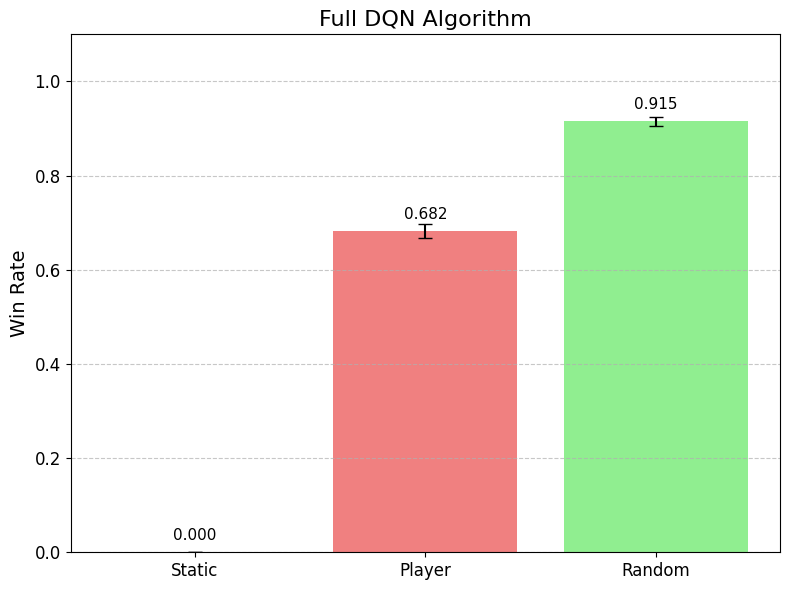

In [111]:
static_board_games, player_board_games, random_board_games = test_model_1000_games(qe_model)
plot_model_test_results("Full DQN Algorithm", static_board_games, player_board_games, random_board_games)

In [114]:
max_games = 1000
wins = 0
for i in range(max_games):
    win,_ = test_model(dqn_model, mode='random', display=False,gif=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 962
Win percentage: 96.2%


Generating 2 frames for GIF...
Rendering frame 1/2... Warning: Using default bitmap font, which may be pixelated at size 30.
Rendering frame 2/2... Warning: Using default bitmap font, which may be pixelated at size 30.

Frame rendering complete.
Generating GIF object for display...
GIF object generated.
Returning IPython.display.Image object.
False


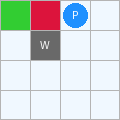

In [115]:
win, gif = test_model(qe_model, mode='static', display=False, gif=True)
print(win)
display(gif)

# Transformer DQN model
This was generated with Gemini 2.5 as an experiment

In [116]:
import torch
import torch.nn as nn
import math

# Assuming input from render_np is (Channels, Height, Width), e.g., (4, 4, 4)
# Let's define dimensions based on this assumption
CHANNELS = 4  # Player, Goal, Pit, Wall layers
HEIGHT = 4
WIDTH = 4
SEQUENCE_LENGTH = HEIGHT * WIDTH # 16 sequence items (one per grid cell)
INPUT_FEATURES_PER_ITEM = CHANNELS # Each item in the sequence has C features

OUTPUT_DIM = 4 # 4 actions

# --- Minimal Transformer DQN ---

class PositionalEncoding(nn.Module):
    """ Simple learned positional encoding """
    def __init__(self, d_model: int, max_len: int = 16): # max_len = H*W
        super().__init__()
        # Learnable embedding parameter for positions
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Add positional embedding to input tensor x
        # Broadcasting applies the same pos_embedding across the batch
        x = x + self.pos_embedding[:, :x.size(1)]
        return x

class TransformerDQN(nn.Module):
    def __init__(self,
                 input_features=INPUT_FEATURES_PER_ITEM, # Features per seq item (Channels)
                 seq_len=SEQUENCE_LENGTH,        # Sequence length (H*W)
                 output_dim=OUTPUT_DIM,          # Q-values for actions
                 d_model=32,                     # Embedding dimension (keep small)
                 nhead=4,                        # Attention heads (must divide d_model)
                 num_encoder_layers=1,           # Number of Transformer blocks (minimal)
                 dim_feedforward=64,             # Hidden dim in Transformer FFN (keep small)
                 dropout=0.1):
        super().__init__()

        if d_model % nhead != 0:
            raise ValueError(f"nhead ({nhead}) must be a divisor of d_model ({d_model})")

        self.d_model = d_model

        # 1. Linear Embedding: Project input features for each sequence item
        # Input: (B, SeqLen, Features) -> Output: (B, SeqLen, d_model)
        self.input_embedding = nn.Linear(input_features, d_model)

        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        # 3. Transformer Encoder Layer(s)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   activation='relu', # or 'gelu'
                                                   batch_first=True) # Crucial: (Batch, Seq, Feature)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=num_encoder_layers)

        # 4. Output Layer (processes the aggregated output)
        # We will aggregate (e.g., mean pool) before this layer in forward()
        self.output_layer = nn.Linear(d_model, output_dim)

        self.activation = nn.ReLU() # Used after input embedding

    def forward(self, state):
        """
        Args:
            state: Input tensor, shape (batch_size, channels, height, width),
                   e.g., (B, 4, 4, 4)
        Returns:
            Q-values tensor, shape (batch_size, output_dim), e.g., (B, 4)
        """
        if not isinstance(state, torch.Tensor):
            # Ensure input is a tensor, move to model's device if needed
            device = next(self.parameters()).device
            state = torch.tensor(state, dtype=torch.float32).to(device)
        elif state.device != next(self.parameters()).device:
             # Ensure tensor is on the correct device
             state = state.to(next(self.parameters()).device)


        # --- Reshape and Embed ---
        # Reshape (B, C, H, W) -> (B, H*W, C) = (B, SeqLen, Features)
        batch_size = state.shape[0]
        # Flatten H and W dimensions, keep C as feature dim, then permute
        x = state.flatten(2).permute(0, 2, 1) # Shape: (B, H*W, C)

        # Apply linear embedding: (B, SeqLen, C) -> (B, SeqLen, d_model)
        x = self.activation(self.input_embedding(x)) # Apply activation after embedding

        # --- Add Positional Encoding ---
        x = self.pos_encoder(x) # Shape: (B, SeqLen, d_model)

        # --- Pass through Transformer Encoder ---
        # Input/Output shape: (B, SeqLen, d_model)
        x = self.transformer_encoder(x)

        # --- Aggregate (Pool) ---
        # Take the mean across the sequence length dimension (dim 1)
        # Shape: (B, SeqLen, d_model) -> (B, d_model)
        x = x.mean(dim=1)

        # --- Output Layer ---
        # Shape: (B, d_model) -> (B, output_dim)
        q_values = self.output_layer(x)

        return q_values


In [119]:
# Define Transformer hyperparameters first
d_model = 32
nhead = 4
num_layers = 1
dim_ff = 64
output_dim = 4 # Keep this

# Instantiate the new model
transformer_dqn_model = TransformerDQN(
    output_dim=output_dim,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dim_feedforward=dim_ff
    # input_features and seq_len usually use defaults based on constants
)

transformer_model2 = copy.deepcopy(transformer_dqn_model) #A
transformer_model2.load_state_dict(transformer_dqn_model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(transformer_dqn_model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3
print("Transformer DQN Model:")
print(transformer_dqn_model)

    # Example input (batch of 2 states, 4 channels, 4x4 grid)
    # MAKE SURE YOUR ACTUAL STATE HAS THIS SHAPE!
example_state_batch = torch.randn(2, CHANNELS, HEIGHT, WIDTH)

    # Get Q-values
transformer_dqn_model.eval() # Set to evaluation mode if not training
with torch.no_grad():
    q_values = transformer_dqn_model(example_state_batch)

print(f"\nInput shape: {example_state_batch.shape}")
print(f"Output Q-values shape: {q_values.shape}") # Should be (2, 4)
print("Example Q-values:\n", q_values)

Transformer DQN Model:
TransformerDQN(
  (input_embedding): Linear(in_features=4, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
  (activation): ReLU()
)

Input shape: torch.Size([2, 4, 4, 4])
Output Q-values s

In [126]:
from collections import deque
epochs = 1000
losses = []
mem_size = 5000
batch_size = 400
replay = deque(maxlen=mem_size)
epsilon_end = 0.01
epsilon_decay_rate = (epsilon - epsilon_end) / epochs
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
pbar = tqdm(range(epochs))
for i in pbar:
    game = Gridworld(size=4, mode='random')
    state1_np = game.board.render_np() 
    noise = np.random.rand(*state1_np.shape) / 100.0
    state1_np = state1_np + noise
    state1_tensor_3d = torch.from_numpy(state1_np).float() # Shape (C, H, W)
    state1 = state1_tensor_3d.unsqueeze(0) # Shape (1, C, H, W) <--- FIX 1
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = transformer_dqn_model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_np = game.board.render_np() # Shape (C, H, W)
        noise = np.random.rand(*state2_np.shape) / 100.0
        state2_np = state2_np + noise
        state2_tensor_3d = torch.from_numpy(state2_np).float() # Shape (C, H, W)
        state2 = state2_tensor_3d.unsqueeze(0) # Shape (1, C, H, W) <--- FIX 1 (Consistency)

        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        # --- Epsilon Decay ---
        epsilon = max(epsilon_end, epsilon - epsilon_decay_rate)
        # --------------------

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = transformer_dqn_model(state1_batch.unsqueeze(0)) 
            with torch.no_grad():
                Q2 = transformer_model2(state2_batch.unsqueeze(0)) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            pbar.set_postfix({'loss': f"{loss.item():.6f}"})
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                transformer_model2.load_state_dict(transformer_dqn_model.state_dict())

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

  1%|          | 11/1000 [00:00<01:08, 14.53it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1600 and 4x32)